In [1]:
import pandas as pd
import numpy as np
import scipy.linalg
from sklearn import svm
from matplotlib import pyplot as plt
import seaborn as sns
from cookbook import Cookbook
import rrcf

%matplotlib inline
sns.set_palette('husl', 2)
np.random.seed(0)

# Load markup document and run markup compiler

In [2]:
mbd = Cookbook('../example/mary-beth-doyle.jsonld')
mbd.run()

# Load data and events from both classes

In [3]:
events = [getattr(mbd, attr) for attr in dir(mbd) if "train_event" in attr]
nonevents = [getattr(mbd, attr) for attr in dir(mbd) if "train_nonevent" in attr]
data = mbd.maxbotix_depth

# Generate training data

In [4]:
# Window points to capture temporal information
shingle_size = 6

# Window points from wave events
event_points = []
for event in events:
    shingle = np.column_stack([event.diff(i) / (1e-9*event.index.to_series().astype(int).diff(i))
                                    for i in range(1, shingle_size)] + [event])
    shingle = shingle[~np.isnan(shingle).any(axis=1)]
    event_points.append(shingle)
event_points = np.vstack(event_points)
    
# Window points from baseline case
nonevent_points = []
for nonevent in nonevents:
    shingle = np.column_stack([nonevent.diff(i) / (1e-9*nonevent.index.to_series().astype(int).diff(i))
                                    for i in range(1, shingle_size)] + [nonevent])
    shingle = shingle[~np.isnan(shingle).any(axis=1)]
    nonevent_points.append(shingle)
nonevent_points = np.vstack(nonevent_points)

# Combine both point sets to form training data
training_points = np.vstack([event_points, nonevent_points])
training_labels = np.concatenate([np.ones(event_points.shape[0]), np.zeros(nonevent_points.shape[0])])

# Train SVM model

In [5]:
# Randomly select 10000 points from training data
ix = np.random.choice(training_points.shape[0], size=10000)

# Fit SVM model
clf = svm.SVC(gamma='scale')
clf.fit(training_points[ix], training_labels[ix])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Generate test data

In [6]:
# Generate windowed test points
points = np.column_stack([data.diff(i) / (1e-9*data.index.to_series().astype(int).diff(i))
                                for i in range(1, shingle_size)] + [data])
points = points[~np.isnan(points).any(axis=1)]

# Predict classes

In [7]:
# Predict classes of test points
predict = clf.predict(points)

# Plot results

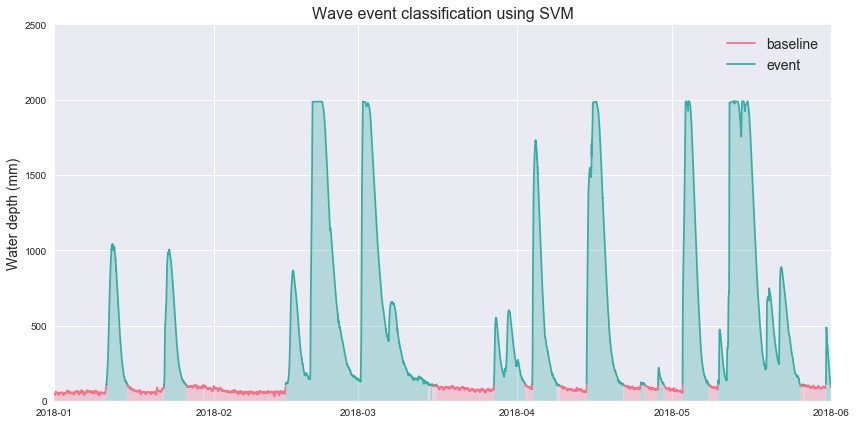

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(data.index[shingle_size-1:], np.where(predict == 0, [point[-1] for point in points], np.nan), label='baseline')
plt.plot(data.index[shingle_size-1:], np.where(predict == 1, [point[-1] for point in points], np.nan), label='event')
plt.fill_between(data.index[shingle_size-1:], np.where(predict == 0, [point[-1] for point in points], np.nan), alpha=0.3)
plt.fill_between(data.index[shingle_size-1:], np.where(predict == 1, [point[-1] for point in points], np.nan), alpha=0.3)
plt.xlim('2018-01-01', '2018-06-01')
plt.ylim(0, 2500)
plt.legend(fontsize=14)
plt.title('Wave event classification using SVM', size=16)
plt.ylabel('Water depth (mm)', size=14)
plt.tight_layout()
plt.savefig('wave_classification.png')